In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/lfw.zip', 'r') as zip_ref:
    zip_ref.extractall('')
path = 'lfw'

In [ ]:

transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [ ]:
# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    print("CUDA not available. Using CPU.")
    device = torch.device("cpu")

CUDA is available. Using GPU.


torch.Size([250, 250, 3])


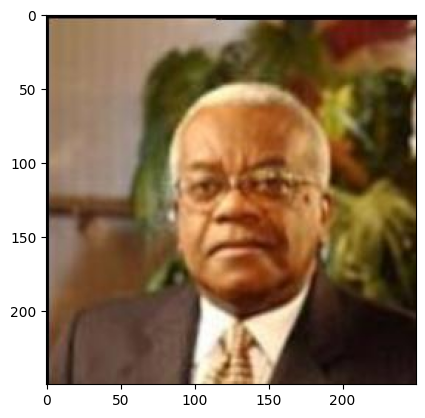

In [ ]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function.

**Autoencoders (AEs):**

1.   Applications:
  *   Data Compression and Denoising: Autoencoders are commonly used for data compression and denoising. They learn to encode input data into a lower-dimensional representation and then decode it back to the original form, helping in removing noise or compressing the data.
2.   Architecture:
  *   Encoder-Decoder Structure: Autoencoders consist of an encoder network that compresses the input data into a lower-dimensional representation (encoding), and a decoder network that reconstructs the input from this encoding.
  Symmetric Structure: The encoder and decoder structures are typically symmetric.
3.   Loss Function:
  *   Reconstruction Loss: The primary loss function in autoencoders is the reconstruction loss, which measures the difference between the input data and the reconstructed output. Mean Squared Error (MSE) is a common choice for continuous data, while binary cross-entropy is used for binary data.





Variational Autoencoders (VAEs):
1.   Applications:
  *   Generative Modeling: VAEs are commonly used for generative modeling. They not only learn a compressed representation but also generate new samples by sampling from the learned latent space.
  Image Generation: VAEs are widely used in generating new images, especially in scenarios where we want to explore diverse samples.
2.   Architecture:
  *   Probabilistic Encoder-Decoder: VAEs introduce a probabilistic approach by treating the encoder as a probabilistic distribution (usually Gaussian) over the latent space. The decoder then samples from this distribution to generate data.
  Reparameterization Trick: To make the training differentiable, the reparameterization trick is used, allowing for backpropagation through the sampling process.
3.   Loss Function:
  *   Variational Loss: VAEs use a combination of a reconstruction loss (similar to AEs) and a variational loss. The variational loss enforces that the learned latent space follows a specific probabilistic distribution, typically a Gaussian. The goal is not only to reconstruct the input but also to regularize the latent space.

*  Autoencoders focus on reconstructing input data and are often used for tasks like data compression and feature learning.
*  Variational Autoencoders extend this by introducing a probabilistic interpretation, making them suitable for generative tasks. VAEs aim to learn a probabilistic distribution in the latent space, enabling the generation of new, similar samples.

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, latent_dims=20, image_channels=3, image_size=250):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(256 * (image_size // 16) * (image_size // 16), latent_dims)
        self.fc_logvar = nn.Linear(256 * (image_size // 16) * (image_size // 16), latent_dims)

        # Decoder
        self.decoder_input = nn.Linear(latent_dims, 256 * (image_size // 16) * (image_size // 16))

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        return self.fc_mu(h), self.fc_logvar(h)

    def decode(self, z):
        h = self.decoder_input(z)
        h = h.view(h.size(0), 256, (image_size // 16), (image_size // 16))
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Instantiate the model
latent_dims = 20
image_channels = 3
image_size = 250
model = VAE(latent_dims, image_channels, image_size)


## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly.

1. **Reparameterization Trick:**

  * Instead of directly sampling from the output of the encoder (which contains mean and log variance), the model samples from a unit Gaussian distribution (torch.randn) and then transforms the samples to match the desired distribution parameters (mu and log_var) using the reparameterization trick.

  * The reparameterization trick is essential for enabling gradient backpropagation through the sampling process, as gradients can flow through the deterministic path. It helps in training the model by making it differentiable.

2. **Generating Samples:**

  * Once the model has the mean (mu) and log variance (log_var) from the encoder and a sampled latent vector (z) using the reparameterization trick, the decoder generates new samples by reconstructing them from the sampled latent vector.

  * The decoder takes the sampled latent vector and produces the output, which, in the context of a VAE, is often a reconstruction of the input data.

In [ ]:
import torch
from torch.utils.data import DataLoader

# Assuming 'dataloader' is an instance of DataLoader and 'device' is defined
# If not, you should create a DataLoader with your dataset and define 'device' accordingly

# Instantiate the VAE model
model = VAE().to(device)

# Iterate over batches in the DataLoader
for batch in dataloader:
    # Move the input data to the device
    images = batch[0].to(device)

    # Pass the batch of images through the model
    with torch.no_grad():  # Use torch.no_grad() to disable gradient computation during inference
        output, mu, log_var = model(images)

    # Print the shape of the output of the encoder
    print(f"Shape of the encoder's output (mu): {mu.shape}")
    print(f"Shape of the encoder's output (log_var): {log_var.shape}")
    print(f"Shape of the samples in the latent space: {mu.shape}")
    print(f"Shape of the decoder's output (generated images): {output.shape}")

    # Exit the loop since we only need one batch
    break


Shape of the encoder's output (mu): torch.Size([32, 20])
Shape of the encoder's output (log_var): torch.Size([32, 20])
Shape of the samples in the latent space: torch.Size([32, 20])
Shape of the decoder's output (generated images): torch.Size([32, 3, 250, 250])


##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


* create an optimizer for training

1. Reconstruction Loss:

  * Purpose: The reconstruction loss measures how well the VAE can reconstruct the input data from the sampled latent vectors. It encourages the model to generate outputs that closely resemble the original inputs.
  *Term in the Loss Function: The reconstruction loss is typically a form of distance or dissimilarity measure between the input data and the reconstructed output. For continuous data, Mean Squared Error (MSE) is commonly used, while binary cross-entropy may be used for binary data.
  *Goal: Minimizing the reconstruction loss ensures that the VAE can faithfully reconstruct the input data, capturing essential features during the encoding and decoding process.

2. Regularization Term (Kullback-Leibler Divergence):

  * Purpose: The regularization term, specifically the Kullback-Leibler (KL) Divergence, encourages the learned latent space to follow a specific probabilistic distribution, typically a Gaussian distribution with zero mean and unit variance. This regularization enforces a smooth and continuous latent space, preventing overfitting and promoting generalization.
  *Term in the Loss Function: The KL Divergence term penalizes the deviation of the learned distribution (encoded by the mean and log variance produced by the encoder) from the desired distribution.
  *Goal: Minimizing the KL Divergence regularizes the latent space, guiding it to conform to a standard Gaussian distribution. This helps prevent the collapse of the latent space and ensures that each dimension of the latent space contributes meaningfully to the generation process.

**Overall Loss Function:**
* The overall loss function of the VAE is the sum of the reconstruction loss and the regularization term. The objective is to find a balance during training, where the model learns to reconstruct input data accurately while simultaneously regularizing the latent space. The loss function can be expressed as follows:

      Total Loss = Reconstruction Loss + KL Divergence


* By minimizing this total loss during training, the VAE learns a latent space that is both expressive for reconstruction and well-structured according to the desired probabilistic distribution.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Count and print the number of trainable parameters
num_parameters = count_parameters(model)
print(f'The model has {num_parameters:,} trainable parameters.')

# Use a more descriptive variable name for the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


The model has 5,207,019 trainable parameters.


In [ ]:
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

1. Learning Rate: Adjust the learning rate. If the learning rate is too high, the model may overshoot the optimal parameters. Conversely, if it is too low, the model may converge too slowly or get stuck in local minima.

2. Model Complexity: The model might be too complex for the given data, leading to overfitting. Consider reducing the model's capacity or applying regularization techniques.

3. Data Issues: Check the quality and preprocessing of your data. Noisy or incorrectly preprocessed data can hinder convergence.

4. Loss Components: Examine the contributions of the reconstruction loss and KL Divergence to the total loss. If one dominates the other, it might be affecting the training dynamics.

5. Training Set Size: If the training set is very small, the model may struggle to generalize. Ensure that your dataset is diverse enough for the task.

6. Check Model Initialization: Ensure that the model parameters are initialized appropriately. Poor initialization can hinder convergence.

7. Monitor Latent Space: If possible, monitor the latent space during training. An excessively collapsed latent space may indicate issues with the regularization term.

8. Gradient Clipping: Apply gradient clipping to prevent exploding gradients, especially if your model has a deep architecture.

In [ ]:
# Number of epochs
num_epochs = 150
print_interval = 5  # Print loss every 5 epochs, for example

for epoch in range(num_epochs):
    total_loss = 0
    for batch_idx, (data, _) in enumerate(dataloader):
        data = data.to(device)

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        recon_batch, mu, logvar = model(data)

        # Compute loss
        loss = loss_function(recon_batch, data, mu, logvar)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Average loss for this epoch
    epoch_loss = total_loss / len(dataloader.dataset)

    if (epoch + 1) % print_interval == 0 or epoch == 0 or epoch == num_epochs - 1:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # You can adjust the condition in the if statement based on your preference for printing



Epoch [1/150], Loss: 92687.4414
Epoch [5/150], Loss: 92590.0467
Epoch [10/150], Loss: 92500.8081
Epoch [15/150], Loss: 92419.7265
Epoch [20/150], Loss: 92338.2299
Epoch [25/150], Loss: 92258.6505
Epoch [30/150], Loss: 92208.5781
Epoch [35/150], Loss: 92168.2026
Epoch [40/150], Loss: 92093.6687
Epoch [45/150], Loss: 92088.3088
Epoch [50/150], Loss: 92012.2268
Epoch [55/150], Loss: 91989.0989
Epoch [60/150], Loss: 91933.0914
Epoch [65/150], Loss: 91909.7689
Epoch [70/150], Loss: 91857.9318
Epoch [75/150], Loss: 91829.5817
Epoch [80/150], Loss: 91794.6734
Epoch [85/150], Loss: 91783.4132
Epoch [90/150], Loss: 91759.5378
Epoch [95/150], Loss: 91722.5986
Epoch [100/150], Loss: 91717.0470
Epoch [105/150], Loss: 91685.9780
Epoch [110/150], Loss: 91645.2006
Epoch [115/150], Loss: 91644.4442
Epoch [120/150], Loss: 91614.7423
Epoch [125/150], Loss: 91584.2957
Epoch [130/150], Loss: 91591.0174
Epoch [135/150], Loss: 91602.5547
Epoch [140/150], Loss: 91560.5943
Epoch [145/150], Loss: 91526.3756
Ep

##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

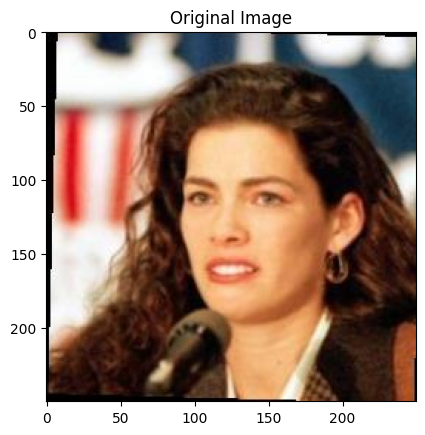

In [ ]:
import matplotlib.pyplot as plt

# After training
model.eval()

with torch.no_grad():
    for i, (data, _) in enumerate(dataloader):
        if i == random.randint(0, len(dataloader)):
            original_image = data[0].to(device)
            plt.imshow(original_image.cpu().permute(1, 2, 0))
            plt.title("Original Image")
            plt.show()
            break

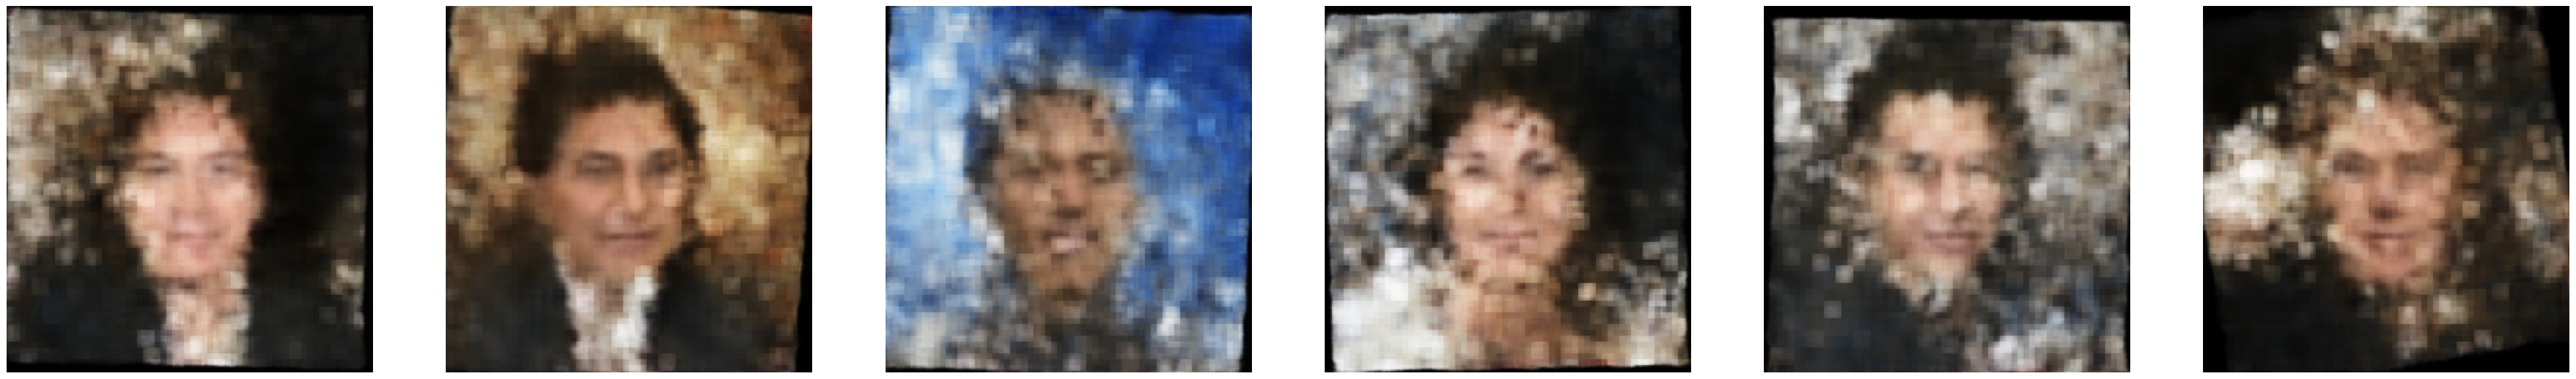

In [ ]:
# Generate new samples and plot them
with torch.no_grad():
    sample = torch.randn(64, 20).to(device)
    generated_images = model.decode(sample).cpu()

    # Plot the generated images
    fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(50, 24))
    for ax, img in zip(axes.flat, generated_images):
        ax.imshow(img.permute(1, 2, 0))
        ax.axis('off')
    plt.show()